# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [91]:
from __future__ import annotations
from typing import TYPE_CHECKING, Any, Callable

import logging
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

if TYPE_CHECKING:
    _1DArray = np.ndarray[tuple[int], np.dtype[np.float64]]
    _2DArray = np.ndarray[tuple[int, int], np.dtype[np.float64]]
    _NDArray = np.ndarray[tuple[int, ...], np.dtype[np.float64]]
    _TrainResult = tuple[_2DArray, dict[str, int], float]


In [92]:
data_hidden_dim = None
data_hidden_layer = None

data_dropout = None
data_l1 = None
data_l2 = None

data_combined_1 = None
data_combined_2 = None
data_combined_3 = None
data_combined_4 = None
data_combined_5 = None
data_combined_6 = None
data_combined_7 = None
data_combined_8 = None

%store -r


In [93]:
from mlp.data_providers import DataProvider, EMNISTDataProvider, MNISTDataProvider
from mlp.errors import CrossEntropySoftmaxError
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.layers import AffineLayer, ReluLayer, SigmoidLayer, SoftmaxLayer
from mlp.learning_rules import AdamLearningRule, GradientDescentLearningRule
from mlp.models import MultipleLayerModel
from mlp.optimisers import Optimiser


def train_model_and_plot_stats(
    model: MultipleLayerModel,
    error: CrossEntropySoftmaxError,
    learning_rule: GradientDescentLearningRule,
    train_data: DataProvider,
    valid_data: DataProvider,
    num_epochs: int,
    stats_interval: int,
    notebook: bool = True,
) -> _TrainResult:

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors: dict[str, Callable[[_NDArray, _NDArray], float]] = {
        "acc": lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()
    }

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        data_monitors,
        notebook=notebook,
    )

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats: _2DArray
    keys: dict[str, int]
    stats, keys, run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval
    )

    # # Plot the change in the validation and training set error over training.
    # fig_1 = plt.figure(figsize=(8, 4))
    # ax_1 = fig_1.add_subplot(111)
    # for k in ['error(train)', 'error(valid)']:
    #     ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
    #               stats[1:, keys[k]], label=k)
    # ax_1.legend(loc=0)
    # ax_1.set_xlabel('Epoch number')

    # # Plot the change in the validation and training set accuracy over training.
    # fig_2 = plt.figure(figsize=(8, 4))
    # ax_2 = fig_2.add_subplot(111)
    # for k in ['acc(train)', 'acc(valid)']:
    #     ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
    #               stats[1:, keys[k]], label=k)
    # ax_2.legend(loc=0)
    # ax_2.set_xlabel('Epoch number')

    # return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
    return stats, keys, run_time


In [94]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.

# Seed a random number generator
seed = 11102019
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider("train", batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider("valid", batch_size=batch_size, rng=rng)


KeysView(<numpy.lib.npyio.NpzFile object at 0x123d202b0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x123d202b0>)


In [95]:
from mlp.layers import DropoutLayer
from mlp.penalties import L1Penalty, L2Penalty

def do_nothing() -> None:
    return None

def run_model(
    hidden_dim: int,
    hidden_layer_count: int,
    dropout: None | Callable[[], DropoutLayer] = None,
    penalty: Callable[[], None | L1Penalty | L2Penalty] = do_nothing,
) -> _TrainResult:
    """
    Run different models specified in the question.
    """
    if hidden_layer_count < 1:
        raise ValueError("There must be at least one hidden layer")

    input_dim, output_dim = 784, 47

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.0)

    layers: list[object] = [
        AffineLayer(
            input_dim,
            hidden_dim,
            weights_init,
            biases_init,
            weights_penalty=penalty(),
            biases_penalty=penalty(),
        ),
        ReluLayer(),
    ]
    if dropout is not None:
        layers.append(dropout())
    for _ in range(hidden_layer_count - 1):
        layers += [
            AffineLayer(
                hidden_dim,
                hidden_dim,
                weights_init,
                biases_init,
                weights_penalty=penalty(),
                biases_penalty=penalty(),
            ),
            ReluLayer(),
        ]
        if dropout is not None:
            layers.append(dropout())
    layers.append(
        AffineLayer(
            hidden_dim,
            output_dim,
            weights_init,
            biases_init,
            weights_penalty=penalty(),
            biases_penalty=penalty(),
        )
    )
    model = MultipleLayerModel(layers)

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    # Remember to use notebook=False when you write a script to be run in a terminal
    return train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        num_epochs,
        stats_interval,
        notebook=True,
    )


In [96]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

# setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
# input_dim, output_dim, hidden_dim = 784, 47, 100

# weights_init = GlorotUniformInit(rng=rng)
# biases_init = ConstantInit(0.)
# model = MultipleLayerModel([
#     AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
#     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
#     AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
# ])

# error = CrossEntropySoftmaxError()
# # Use a basic gradient descent learning rule
# learning_rule = AdamLearningRule()

# #Remember to use notebook=False when you write a script to be run in a terminal
# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)


In [97]:
def gen_stat_str(data: _TrainResult) -> str:
    """
    Generate stat string.
    """
    stats, keys, *_ = data
    # Only print the first time
    sorted_keys = sorted(keys.items(), key=itemgetter(1))
    return ", ".join(
        f"{k[0]}={v:.2e}" for (k, v) in zip(sorted_keys, stats[-1])
    )

In [98]:
def plot_fig_2_3(data: dict[int, _TrainResult], prefix: str) -> None:
    """
    Plot utility function for Fig. 2 and 3.
    """
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)

    for i, (t, linestyle) in enumerate({"(train)": "-", "(valid)": "--"}.items()):
        for w, datum in data.items():
            stats, keys, *_ = datum
            if not i:
                # Only print the first time
                print(f"{w}: {gen_stat_str(datum)}")
            ax_1.plot(
                np.arange(1, stats.shape[0]) * stats_interval,
                stats[1:, keys[f"error{t}"]],
                label=f"{prefix} {w}{t}",
                linestyle=linestyle,
            )
            ax_2.plot(
                np.arange(1, stats.shape[0]) * stats_interval,
                stats[1:, keys[f"acc{t}"]],
                label=f"{prefix} {w}{t}",
                linestyle=linestyle,
            )

    ax_1.legend(loc=0)
    ax_1.set_xlabel("Epoch number")
    ax_2.legend(loc=0)
    ax_2.set_xlabel("Epoch number")


In [99]:
if data_hidden_dim is None:
    data_hidden_dim = {
        32: run_model(32, 1),
        64: run_model(64, 1),
        128: run_model(128, 1),
    }
    %store data_hidden_dim
for dim, data in data_hidden_dim.items():
    print(f"Dimension {dim} run time: {data[2]:.3f} seconds")


Dimension 32 run time: 191.215 seconds
Dimension 64 run time: 281.809 seconds
Dimension 128 run time: 370.959 seconds


32: error(train)=5.65e-01, acc(train)=8.20e-01, error(valid)=7.17e-01, acc(valid)=7.85e-01
64: error(train)=3.37e-01, acc(train)=8.82e-01, error(valid)=6.79e-01, acc(valid)=8.06e-01
128: error(train)=1.59e-01, acc(train)=9.39e-01, error(valid)=9.99e-01, acc(valid)=8.02e-01


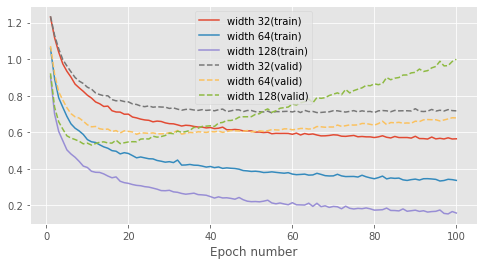

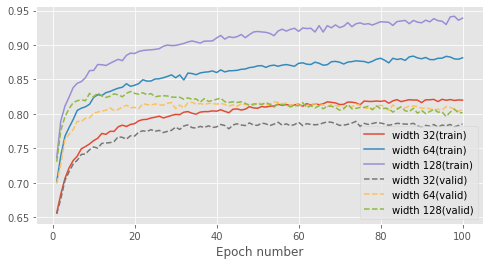

In [100]:
plot_fig_2_3(data_hidden_dim, "width")


In [101]:
if data_hidden_layer is None:
    data_hidden_layer = {
        1: data_hidden_dim[128],
        2: run_model(128, 2),
        3: run_model(128, 3),
    }
    %store data_hidden_layer
for layer, data in data_hidden_layer.items():
    print(f"Layer {layer} run time: {data[2]:.3f} seconds")


Layer 1 run time: 370.959 seconds
Layer 2 run time: 404.294 seconds
Layer 3 run time: 465.314 seconds


1: error(train)=1.59e-01, acc(train)=9.39e-01, error(valid)=9.99e-01, acc(valid)=8.02e-01
2: error(train)=9.89e-02, acc(train)=9.59e-01, error(valid)=1.56e+00, acc(valid)=8.17e-01
3: error(train)=1.05e-01, acc(train)=9.59e-01, error(valid)=1.65e+00, acc(valid)=8.23e-01


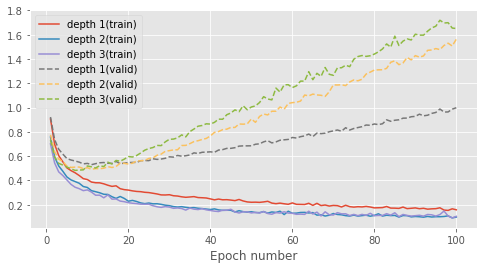

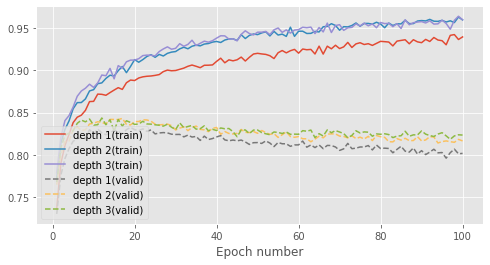

In [102]:
plot_fig_2_3(data_hidden_layer, "depth")


In [103]:
def plot_fig_valid(data: dict[float, _TrainResult], prefix: str) -> None:
    """
    Plot utility function for Fig. 2 and 3.
    """
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)

    for w, datum in data.items():
        stats, keys, *_ = datum
        # Only print the first time
        print(f"{w}: {gen_stat_str(datum)}")
        ax_1.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys["error(valid)"]],
            label=f"{prefix} {w}(valid)",
        )
        ax_2.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys["acc(valid)"]],
            label=f"{prefix} {w}(valid)",
        )

    ax_1.legend(loc=0)
    ax_1.set_xlabel("Epoch number")
    ax_2.legend(loc=0)
    ax_2.set_xlabel("Epoch number")


In [104]:
if data_dropout is None:
    data_dropout = {
        prob: run_model(128, 3, dropout=lambda: DropoutLayer(incl_prob=prob))
        for prob in [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    %store data_dropout
for prob, data in data_dropout.items():
    print(f"Dropout probability {prob} run time: {data[2]:.3f} seconds")


Dropout probability 0.1 run time: 687.410 seconds
Dropout probability 0.3 run time: 639.080 seconds
Dropout probability 0.5 run time: 645.552 seconds
Dropout probability 0.7 run time: 703.483 seconds
Dropout probability 0.9 run time: 721.699 seconds


In [105]:
def gen_acc_gap_str(data: _TrainResult) -> str:
    """
    Generate accuracy and gap string.
    """
    stat: _1DArray = data[0][-1]
    keys = data[1]
    acc = stat[keys["acc(valid)"]]
    gap = stat[keys["error(valid)"]] - stat[keys["error(train)"]]
    return f"Accuracy {acc:.2e}, Gap {gap:.2e}"

In [106]:
def plot_fig_4_dropout(data: dict[float, _TrainResult]) -> None:
    """
    Plot utility function for Fig. 4 dropout.
    """
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    accs: list[float] = []
    gaps: list[float] = []
    for dropout, datum in data.items():
        print(f"Dropout {dropout}: {gen_acc_gap_str(datum)}")
        stat: _1DArray = datum[0][-1]
        keys = datum[1]
        accs.append(stat[keys["acc(valid)"]])
        gaps.append(stat[keys["error(valid)"]] - stat[keys["error(train)"]])

    l1 = ax1.plot(data.keys(), accs, "r", label="Val. Acc.")
    l2 = ax2.plot(data.keys(), gaps, "b", label="Gap")
    lines = l1 + l2
    labels = [l.get_label() for l in lines]

    ax1.legend(lines, labels, loc=0)
    ax1.set_xlabel("Dropout value")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Generalization gap")


Dropout 0.1: Accuracy 1.89e-02, Gap -4.78e-04
Dropout 0.3: Accuracy 2.96e-01, Gap 4.33e-02
Dropout 0.5: Accuracy 8.15e-01, Gap 6.62e-02
Dropout 0.7: Accuracy 8.47e-01, Gap 1.29e-01
Dropout 0.9: Accuracy 8.53e-01, Gap 2.88e-01


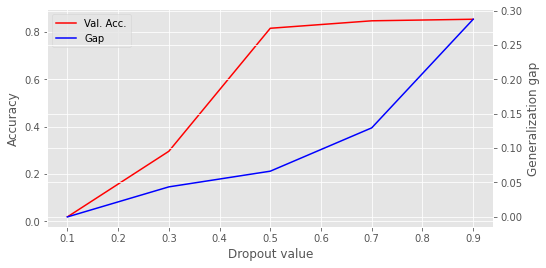

In [107]:
plot_fig_4_dropout(data_dropout)


0.1: error(train)=5.05e+00, acc(train)=2.14e-02, error(valid)=5.05e+00, acc(valid)=1.89e-02
0.3: error(train)=2.46e+00, acc(train)=3.09e-01, error(valid)=2.50e+00, acc(valid)=2.96e-01
0.5: error(train)=5.22e-01, acc(train)=8.31e-01, error(valid)=5.88e-01, acc(valid)=8.15e-01
0.7: error(train)=3.23e-01, acc(train)=8.81e-01, error(valid)=4.52e-01, acc(valid)=8.47e-01
0.9: error(train)=1.97e-01, acc(train)=9.21e-01, error(valid)=4.85e-01, acc(valid)=8.53e-01


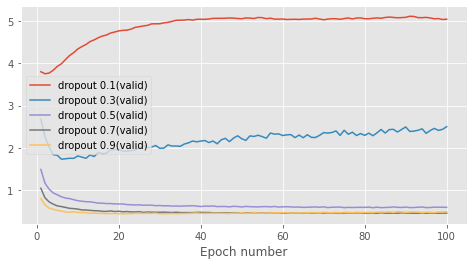

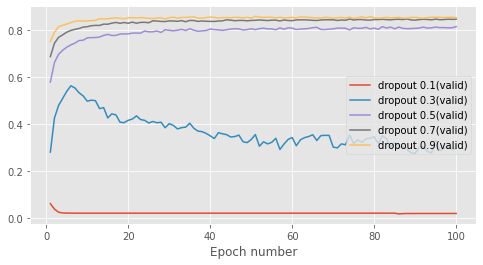

In [108]:
plot_fig_valid(data_dropout, "dropout")


In [109]:
def plot_fig_4_penalty(data: dict[float, _TrainResult], type_: str) -> None:
    """
    Plot utility function for Fig. 4 penalty.
    """
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    accs: list[float] = []
    gaps: list[float] = []
    for value, datum in data.items():
        print(f"{type_} {value}: {gen_acc_gap_str(datum)}")
        stat: _1DArray = datum[0][-1]
        keys = datum[1]
        accs.append(stat[keys["acc(valid)"]])
        gaps.append(stat[keys["error(valid)"]] - stat[keys["error(train)"]])

    l1 = ax1.plot(data.keys(), accs, "r", label="Val. Acc.")
    l2 = ax2.plot(data.keys(), gaps, "b", label="Gap")
    lines = l1 + l2
    labels = [l.get_label() for l in lines]

    ax1.legend(lines, labels, loc=0)
    ax1.set_xscale("log")
    ax1.set_xlabel(f"{type_} value")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Generalization gap")


In [110]:
if data_l1 is None:
    data_l1 = {
        pen: run_model(128, 3, penalty=lambda: L1Penalty(pen))
        for pen in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }
    %store data_l1
for pen, data in data_l1.items():
    print(f"L1 penalty {pen} run time: {data[2]:.3f} seconds")


L1 penalty 1e-05 run time: 582.968 seconds
L1 penalty 0.0001 run time: 550.732 seconds
L1 penalty 0.001 run time: 555.729 seconds
L1 penalty 0.01 run time: 555.588 seconds
L1 penalty 0.1 run time: 623.789 seconds


L1 1e-05: Accuracy 8.31e-01, Gap 8.02e-01
L1 0.0001: Accuracy 8.52e-01, Gap 9.72e-02
L1 0.001: Accuracy 7.54e-01, Gap 8.18e-03
L1 0.01: Accuracy 2.01e-02, Gap 7.63e-06
L1 0.1: Accuracy 2.16e-02, Gap 2.31e-07


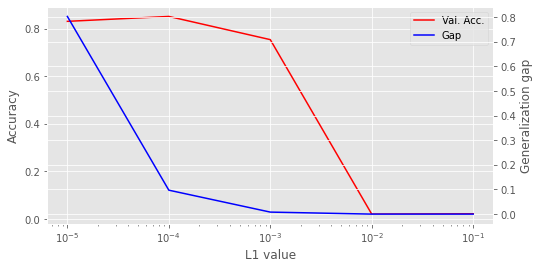

In [111]:
plot_fig_4_penalty(data_l1, "L1")


1e-05: error(train)=1.43e-01, acc(train)=9.43e-01, error(valid)=9.45e-01, acc(valid)=8.31e-01
0.0001: error(train)=3.41e-01, acc(train)=8.76e-01, error(valid)=4.38e-01, acc(valid)=8.52e-01
0.001: error(train)=7.77e-01, acc(train)=7.58e-01, error(valid)=7.85e-01, acc(valid)=7.54e-01
0.01: error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=2.01e-02
0.1: error(train)=3.85e+00, acc(train)=2.12e-02, error(valid)=3.85e+00, acc(valid)=2.16e-02


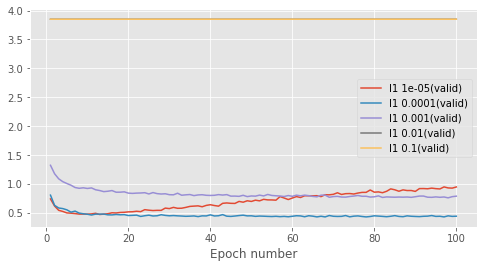

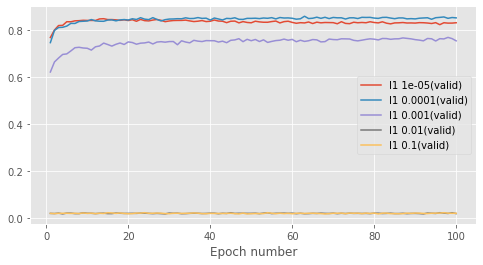

In [112]:
plot_fig_valid(data_l1, "l1")


In [113]:
if data_l2 is None:
    data_l2 = {
        pen: run_model(128, 3, penalty=lambda: L2Penalty(pen))
        for pen in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }
    %store data_l2
for pen, data in data_l2.items():
    print(f"L2 penalty {pen} run time: {data[2]:.3f} seconds")


L2 penalty 1e-05 run time: 824.397 seconds
L2 penalty 0.0001 run time: 765.897 seconds
L2 penalty 0.001 run time: 478.343 seconds
L2 penalty 0.01 run time: 441.872 seconds
L2 penalty 0.1 run time: 486.303 seconds


L2 1e-05: Accuracy 8.22e-01, Gap 1.19e+00
L2 0.0001: Accuracy 8.31e-01, Gap 5.34e-01
L2 0.001: Accuracy 8.53e-01, Gap 6.53e-02
L2 0.01: Accuracy 7.65e-01, Gap 6.90e-03
L2 0.1: Accuracy 1.88e-02, Gap 1.40e-04


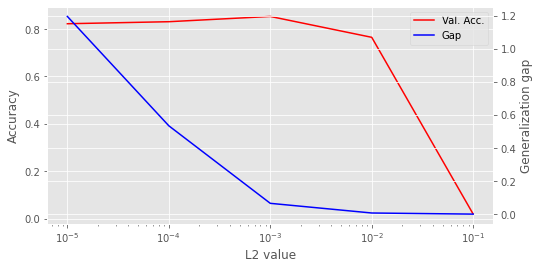

In [114]:
plot_fig_4_penalty(data_l2, "L2")


1e-05: error(train)=1.13e-01, acc(train)=9.55e-01, error(valid)=1.31e+00, acc(valid)=8.22e-01
0.0001: error(train)=1.47e-01, acc(train)=9.41e-01, error(valid)=6.81e-01, acc(valid)=8.31e-01
0.001: error(train)=3.55e-01, acc(train)=8.74e-01, error(valid)=4.20e-01, acc(valid)=8.53e-01
0.01: error(train)=8.12e-01, acc(train)=7.68e-01, error(valid)=8.19e-01, acc(valid)=7.65e-01
0.1: error(train)=3.85e+00, acc(train)=2.14e-02, error(valid)=3.85e+00, acc(valid)=1.88e-02


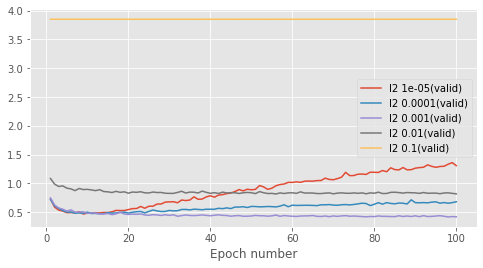

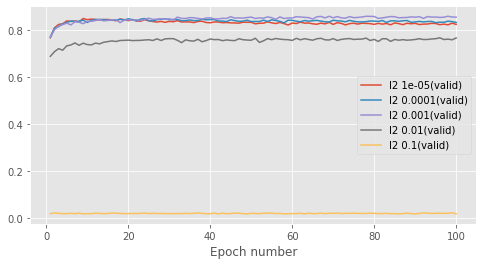

In [115]:
plot_fig_valid(data_l2, "l2")


In [116]:
if data_combined_1 is None:
    data_combined_1 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.5),
        penalty=lambda: L1Penalty(1e-4),
    )
    %store data_combined_1
data_combined_1_name = "Dropout 0.5 & L1 1e-4"
print(f"{data_combined_1_name}: Run time {data_combined_1[2]:.3f} seconds")


Dropout 0.5 & L1 1e-4: Run time 623.652 seconds


In [117]:
print(f"{data_combined_1_name}: {gen_acc_gap_str(data_combined_1)}")
print(f"{data_combined_1_name}: {gen_stat_str(data_combined_1)}")


Dropout 0.5 & L1 1e-4: Accuracy 7.10e-01, Gap 1.52e-02
Dropout 0.5 & L1 1e-4: error(train)=1.03e+00, acc(train)=7.14e-01, error(valid)=1.04e+00, acc(valid)=7.10e-01


In [118]:
if data_combined_2 is None:
    data_combined_2 = run_model(
        128,
        3,
        dropout=lambda: DropoutLayer(incl_prob=0.5),
        penalty=lambda: L2Penalty(1e-3),
    )
    %store data_combined_2
data_combined_2_name = "Dropout 0.5 & L2 1e-3"
print(f"{data_combined_2_name}: Run time {data_combined_2[2]:.3f} seconds")


Dropout 0.5 & L2 1e-3: Run time 562.524 seconds


In [119]:
print(f"{data_combined_2_name}: {gen_acc_gap_str(data_combined_2)}")
print(f"{data_combined_2_name}: {gen_stat_str(data_combined_2)}")


Dropout 0.5 & L2 1e-3: Accuracy 7.19e-01, Gap 1.47e-02
Dropout 0.5 & L2 1e-3: error(train)=9.40e-01, acc(train)=7.23e-01, error(valid)=9.55e-01, acc(valid)=7.19e-01
